In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# =====================================================
# 1️⃣ Define the same model architecture used in training
# =====================================================
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


# =====================================================
# 2️⃣ Initialize model (match training settings exactly)
# =====================================================
in_channels = 4        # or 8 if you used more features (e.g. NDVI, NDWI, NDMI, Temperature)
hidden_channels = 32
out_channels = 1
heads = 4
dropout = 0.3

model = GATModel(in_channels, hidden_channels, out_channels, heads, dropout)

# =====================================================
# 3️⃣ Load model weights safely
# =====================================================
checkpoint_path = "gat_k20_drop0.3_unc4_best.pt"
state_dict = torch.load(checkpoint_path, map_location="cpu")

try:
    model.load_state_dict(state_dict)
    print("✅ Model loaded successfully.")
except RuntimeError as e:
    print("⚠️ Mismatch detected — partial loading.")
    model_dict = model.state_dict()
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(filtered_dict)} matching layers. Others skipped.")

model.eval()

# =====================================================
# 4️⃣ Load the new river CSV data
# =====================================================
data_path = "river.csv"
df = pd.read_csv(data_path)
print("📂 CSV loaded:", df.shape)

# === Columns used for prediction ===
feature_cols = ['Band_3', 'Band_4', 'Band_5', 'Band_7']  # change as needed
X_raw = df[feature_cols].values

# =====================================================
# 5️⃣ Normalize features (using saved scaler or fallback)
# =====================================================
try:
    scaler = joblib.load("scaler.pkl")
    print("✅ Loaded saved scaler.")
    X_scaled = scaler.transform(X_raw)
except:
    print("⚠️ No saved scaler found. Using temporary StandardScaler (approximation).")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

X = torch.tensor(X_scaled, dtype=torch.float)

# =====================================================
# 6️⃣ Create dummy or spatial graph structure
# =====================================================
# If you don't have edge_index, we use dummy (no edges)
edge_index = torch.zeros((2, 0), dtype=torch.long)

# =====================================================
# 7️⃣ Predict salinity
# =====================================================
with torch.no_grad():
    y_pred = model(X, edge_index).squeeze().numpy()

df['Predicted_Salinity'] = y_pred

# =====================================================
# 8️⃣ Save predictions
# =====================================================
output_file = "predicted_salinity.csv"
df.to_csv(output_file, index=False)
print(f"✅ Prediction completed! Saved to '{output_file}'")

# =====================================================
# 9️⃣ Optional — show preview
# =====================================================
print(df.head())


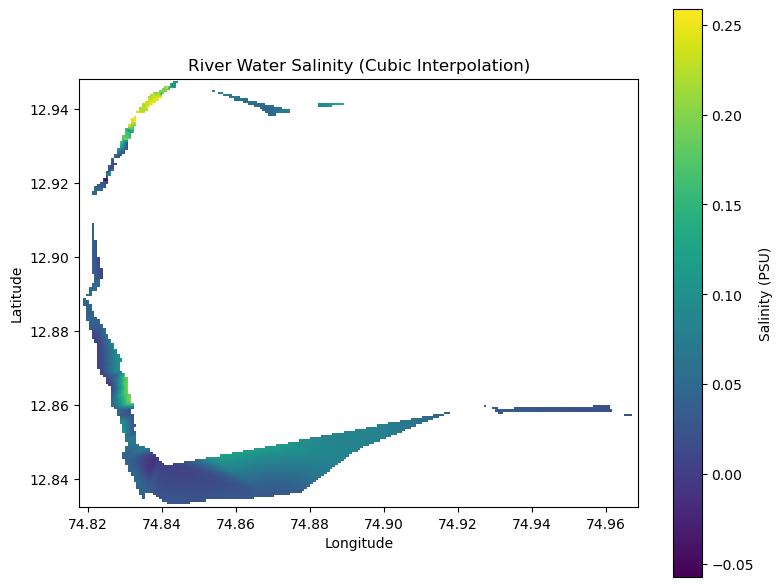

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

# Load CSV with columns: latitude, longitude, salinity
df = pd.read_csv("predicted_salinity.csv")

# Remove invalid salinity values
df = df[df["Predicted_Salinity"].between(0, 50)]

# Create grid
lon = df["longitude"].values
lat = df["latitude"].values
sal = df["Predicted_Salinity"].values

# Grid definition
grid_x, grid_y = np.mgrid[lon.min():lon.max():200j, lat.min():lat.max():200j]

# Interpolation
grid_sal = griddata((lon, lat), sal, (grid_x, grid_y), method="cubic")

# Mask outside convex hull
points = np.vstack((lon, lat)).T
hull = Polygon(points)
mask = np.array([[hull.contains(Point(x, y)) for y in grid_y[0]] for x in grid_x[:,0]])
grid_sal[~mask] = np.nan

# Plot
plt.figure(figsize=(8,6))
plt.imshow(
    grid_sal.T, 
    extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
    origin='lower', 
    cmap='viridis'
)
plt.colorbar(label='Salinity (PSU)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River Water Salinity (Cubic Interpolation)')
plt.tight_layout()
plt.show()
